In [1]:
import time
import numpy as np

from pycuda import gpuarray
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

#import matplotlib as mpl
#mpl.use('agg')
import matplotlib.pyplot as plt
from matplotlib.image import imread

import math

In [2]:
nn_kernel = """
     #include <string.h>
     #define RIGHT 0
     #define RIGHT_CORNER 1
     #define BOTTOM 2
   __device__ float closest_pixel( int r, int c, char region,float *im, int h, int w); 
   __device__ bool is_out_of_bounds(int r, int c, int h,int w);
   
   __global__ void nearn(float *out_r,float *out_g,float *out_b,float *in, const unsigned int h, unsigned int w)
   {
   int c = blockIdx.x*blockDim.x + threadIdx.x;
   int r = blockIdx.y*blockDim.y + threadIdx.y;
   
   if (r < h && c < w)
   {
   if (r%2 == 0) // RED GREEN pattern row
   {
   if (c%2 ==0) // red pixel
   {
   out_r[r*w+c] = in[r*w+c];
   out_g[r*w+c] = closest_pixel(r,c,RIGHT,in,h,w);
   out_b[r*w+c] = closest_pixel(r,c,RIGHT_CORNER,in,h,w);
   }
   else // green pixel
   {
   out_r[r*w+c] = closest_pixel(r,c,RIGHT,in,h,w);
   out_g[r*w+c] = in[r*w+c];
   out_b[r*w+c] = closest_pixel(r,c,BOTTOM,in,h,w);
   }
   }
   else //GREEN BLUE PATTERN
   {
   if (c%2 ==0) // green green
   {
   out_r[r*w+c] = closest_pixel(r,c,BOTTOM,in,h,w);
   out_g[r*w+c] = in[r*w+c];
   out_b[r*w+c] = closest_pixel(r,c,RIGHT,in,h,w);
   }
   else //blue pixel
   {
   out_r[r*w+c] = closest_pixel(r,c,RIGHT_CORNER,in,h,w);
   out_g[r*w+c] = closest_pixel(r,c,RIGHT,in,h,w);
   out_b[r*w+c] = in[r*w+c];
   }
   }
   }
   }
   
   __device__ float closest_pixel(int r, int c, char region,float *im, int h, int w)
   {
   if (region == RIGHT)
   {
   if (is_out_of_bounds(r,c+1,h,w))
   {
   return im[r*w + (c-1)];
   }
   else
   {
   return im[r*w + (c+1)];
   }
   }
   
   else if (region == RIGHT_CORNER)
   {
   if (is_out_of_bounds(r+1,c+1,h,w))
   {
   return im[(r-1)*w + (c-1)];
   }
   else
   {
   return im[(r+1)*w + (c+1)];
   }
   }
   else
   {
   if (is_out_of_bounds(r+1,c,h,w))
   {
   return im[(r-1)*w + c];
   }
   else
   {
   return im[(r+1)*w + c];
   }
   }
   }
   
   
   __device__ bool is_out_of_bounds(int r, int c, int h,int w)
   {
   return (r<0 || r>=h || c < 0 || c>=w);
   
   }"""
   
   

In [29]:
agb_kernel = """
#include <stdlib.h>
//#include <thrust/host_vector.h>
//#include <thrust/device_vector.h>

class Pixel 
{
public:
    int x, y;
     
    Pixel()
    {
    Pixel(-1,-1);
    }
 
    Pixel(int a, int b)
    {
        x = a;
        y= b;
    }
};


__device__ float get_pixel_value(float *im, int h,int w,int *l,int *r,int *t,int* b);

__device__ bool is_valid_pair(int *ind1,int *ind2,int h, int w);

__device__ bool is_valid_pixel(int *ind, int h, int w);

__device__ float average_of_valid_pixels(int *l, int *r,int *t,int *b,float *im,int h,int w);

__device__ float average_of_two(int *p1,int *p2, float *im, int h, int w);

 __global__ void agb(float *out_r,float *out_g,float *out_b,float *in, const unsigned int h, unsigned int w)
 
 {
 int c = blockIdx.x*blockDim.x + threadIdx.x;
 int r = blockIdx.y*blockDim.y + threadIdx.y;
 
 if (c < w && r < h)
 {
 int left_top[2] = {r-1,c-1};
 int  mid_top[2] = {r-1,c};
 int right_top[2] = {r-1,c+1};
 
 int left_mid[2] = {r,c-1};
 int right_mid[2] = {r,c+1};
 int bottom_left[2] = {r+1,c-1};
 int bottom_mid[2] = {r+1,c};
 int bottom_right[2] = {r+1,c+1};
 
 float image_shared[9];
 if (r < h && c < w)
 {
 if (r)
 }
 if (r%2 ==0)
 {
 if (c%2 ==0)
 {
 out_r[r*w+c] = in[r*w+c];
 out_g[r*w+c] = get_pixel_value(in,h,w, left_mid, right_mid, mid_top, bottom_mid);
 out_b[r*w+c] = get_pixel_value(in,h,w, left_top, bottom_right, bottom_left, right_top);
 }
 else
 {
 out_r[r*w+c] = average_of_two(left_mid, right_mid, in, h,w);
 out_g[r*w+c] = in[r*w+c];
 out_b[r*w+c] = average_of_two(mid_top, bottom_mid, in,h,w);

 }
 }
 else
 {
 if (c%2 ==0)
 {
 out_r[r*w+c] = average_of_two(mid_top, bottom_mid, in,h,w);
 out_g[r*w+c] = in[r*w+c];
 out_b[r*w+c] =average_of_two(left_mid, right_mid, in,h,w);
 
 }
 else
 {
 out_r[r*w+c] = get_pixel_value(in, h, w, left_top, bottom_right, bottom_left, right_top);
 out_g[r*w+c] = get_pixel_value(in, h, w, left_mid, right_mid, mid_top, bottom_mid);
 out_b[r*w+c] = in[r*w+c];
 }
 }
 }
 }
 
 __device__ float get_pixel_value(float *im,int h,int w, int *l,int *r,int *t,int *b)
 {
 if (is_valid_pair(l, r, h,w) and is_valid_pair(t, b, h,w))
 {
      float  top_pixel = im[t[0]*w+t[1]];
      float bottom_pixel = im[b[0]*w+b[1]];
      float left_pixel = im[l[0]*w+l[1]];
      float right_pixel = im[r[0]*w+r[1]];
        if (abs(top_pixel - bottom_pixel) > abs(left_pixel - right_pixel))
        {
            return ((left_pixel + right_pixel) / 2);
            }
        else
        {
            return ((top_pixel + bottom_pixel) / 2);
            }
   }
    else // At least one of the index pairs are out of bounds
    {
        return average_of_valid_pixels(l, r, t, b, im, h,w);
        }
 }
 
 __device__ bool is_valid_pair(int *ind1,int *ind2,int h, int w)
 {
 return ((is_valid_pixel(ind1,h,w)) && (is_valid_pixel(ind2,h,w)));
 }


__device__ bool is_valid_pixel(int *ind, int h, int w)
{
if (ind[1] < 0 || ind[1] >= w || ind[0] < 0 || ind[0] >= h) 
{
     return false;
}
return true;
}

__device__ float average_of_valid_pixels(int *l, int *r,int *t,int *b,float *im, int h, int w)
{

float temp = 0;
int count = 0;

//thrust::host_vector<Pixel> pixels(4);

int pixels [] = {l[0],l[1], r[0],r[1] ,t[0], t[1],b[0],b[1]};

for(int p = 0; p < 8; p+=2)
{
//Pixel temp1 = pixels[p];
if (!(pixels[p+1] < 0 || pixels[p+1] >= w || pixels[p] < 0 || pixels[p] >= h))
{
temp += im[(pixels[p])*w + (pixels[p+1])];
count +=1;
}

}

return (temp/count);
}


__device__ float average_of_two(int *p1,int *p2, float *im, int h, int w)

{
if (is_valid_pair(p1, p2,h,w))
{
return ((im[(p1[0])*w + p1[1]] + im[(p2[0])*w + p2[1]])/2);
}
else if (is_valid_pixel(p1,h,w))
{
return im[p1[0]*w + p1[1]];
}
else
{
return im[p2[0]*w + p2[1]];
}
}"""

In [52]:
bilinear_kernel = """
#include <stdlib.h>
//#include <thrust/host_vector.h>
//#include <thrust/device_vector.h>

class Pixel 
{
public:
    int x, y;
     
    Pixel()
    {
    Pixel(-1,-1);
    }
 
    Pixel(int a, int b)
    {
        x = a;
        y= b;
    }
};


//__device__ float get_pixel_value(float *im, int h,int w,int *l,int *r,int *t,int* b);

__device__ bool is_valid_pair(int *ind1,int *ind2,int h, int w);

__device__ bool is_valid_pixel(int *ind, int h, int w);

__device__ float average_of_valid_pixels(int *l, int *r,int *t,int *b,float *im,int h,int w);

__device__ float average_of_two(int *p1,int *p2, float *im, int h, int w);

 __global__ void bilinear(float *out_r,float *out_g,float *out_b,float *in, const unsigned int h, unsigned int w)
 
 {
 int c = blockIdx.x*blockDim.x + threadIdx.x;
 int r = blockIdx.y*blockDim.y + threadIdx.y;

 int left_top[2] = {r-1,c-1};
 int  mid_top[2] = {r-1,c};
 int right_top[2] = {r-1,c+1};
 
 int left_mid[2] = {r,c-1};
 int right_mid[2] = {r,c+1};
 int bottom_left[2] = {r+1,c-1};
 int bottom_mid[2] = {r+1,c};
 int bottom_right[2] = {r+1,c+1};
 
 if (r%2 ==0)
 {
 if (c%2 ==0)
 {
 out_r[r*w+c] = in[r*w+c];
 out_g[r*w+c] = average_of_valid_pixels(left_mid, right_mid, mid_top, bottom_mid, in,h,w);
 out_b[r*w+c] = average_of_valid_pixels(left_top, bottom_right, bottom_left, right_top, in,h,w);
 }
 else
 {
 out_r[r*w+c] = average_of_two(left_mid, right_mid, in, h,w);
 out_g[r*w+c] = in[r*w+c];
 out_b[r*w+c] = average_of_two(mid_top, bottom_mid, in,h,w);

 }
 }
 else
 {
 if (c%2 ==0)
 {
 out_r[r*w+c] = average_of_two(mid_top, bottom_mid, in,h,w);
 out_g[r*w+c] = in[r*w+c];
 out_b[r*w+c] =average_of_two(left_mid, right_mid, in,h,w);
 
 }
 else
 {
 out_r[r*w+c] = average_of_valid_pixels(left_top, bottom_right, bottom_left, right_top, in,h,w);
 out_g[r*w+c] = average_of_valid_pixels(left_mid, right_mid, mid_top, bottom_mid, in,h,w);
 out_b[r*w+c] = in[r*w+c];
 }
 }
 }
 }
 
 
 __device__ bool is_valid_pair(int *ind1,int *ind2,int h, int w)
 {
 return ((is_valid_pixel(ind1,h,w)) && (is_valid_pixel(ind2,h,w)));
 }


__device__ bool is_valid_pixel(int *ind, int h, int w)
{
if (ind[1] < 0 || ind[1] >= w || ind[0] < 0 || ind[0] >= h) 
{
     return false;
}
return true;
}

__device__ float average_of_valid_pixels(int *l, int *r,int *t,int *b,float *im, int h, int w)
{

float temp = 0;
int count = 0;

//thrust::host_vector<Pixel> pixels(4);

int pixels [] = {l[0],l[1], r[0],r[1] ,t[0], t[1],b[0],b[1]};

for(int p = 0; p < 8; p+=2)
{
//Pixel temp1 = pixels[p];
if (!(pixels[p+1] < 0 || pixels[p+1] >= w || pixels[p] < 0 || pixels[p] >= h))
{
temp += im[(pixels[p])*w + (pixels[p+1])];
count +=1;
}

}

return (temp/count);
}


__device__ float average_of_two(int *p1,int *p2, float *im, int h, int w)

{
if (is_valid_pair(p1, p2,h,w))
{
return ((im[(p1[0])*w + p1[1]] + im[(p2[0])*w + p2[1]])/2);
}
else if (is_valid_pixel(p1,h,w))
{
return im[p1[0]*w + p1[1]];
}
else
{
return im[p2[0]*w + p2[1]];
}
}"""


In [53]:
mod = SourceModule(bilinear_kernel)

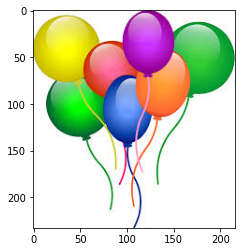

In [54]:
im = imread('balloons.jpg')
im = im/255
plt.imshow(im)

In [55]:
im.shape

(233, 216, 3)

In [56]:
mosaic = im[:, :, 1].copy() # green
mosaic[::2, ::2] = im[::2, ::2, 0] # red
mosaic[1::2, 1::2] = im[1::2, 1::2, 2] # blue

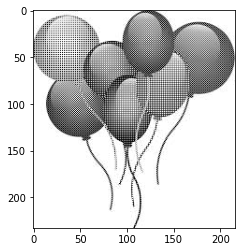

In [57]:
plt.imshow(mosaic,cmap='gray')

In [58]:
h,w = mosaic.shape

In [59]:
out = np.zeros((h,w)).astype(np.float32)

In [60]:
mosaic = mosaic.astype(np.float32)

In [61]:
func = mod.get_function("bilinear")
bdim_x = int(math.ceil(mosaic.shape[0]/2))
bdim_y = int(math.ceil(mosaic.shape[1]/2))
c = np.zeros((mosaic.shape[0],mosaic.shape[1],3),dtype=np.float32)
if bdim_x >= bdim_y:
    bdim = bdim_x
else:
    bdim = bdim_y
#print(bdim)
#out_r = out[:,:,0]
#out_g = out[:,:,1]
#out_b = out[:,:,2]

block_dim = (4,4,1)
grid_dim = (bdim,bdim,1)
e_start = cuda.Event()
e_end = cuda.Event()
e_start.record()
pycuda.driver.Context.synchronize()
a_gpu = cuda.mem_alloc(mosaic.size * mosaic.dtype.itemsize)
#b_gpu = cuda.mem_alloc(K.size * K.dtype.itemsize)
out_r_gpu = cuda.mem_alloc(out.size * out.dtype.itemsize)
out_g_gpu = cuda.mem_alloc(out.size * out.dtype.itemsize)
out_b_gpu = cuda.mem_alloc(out.size * out.dtype.itemsize)
cuda.memcpy_htod(a_gpu,mosaic)
cuda.memcpy_htod(out_r_gpu,out)
cuda.memcpy_htod(out_g_gpu,out)
cuda.memcpy_htod(out_b_gpu,out)
        # Record execution time and execute operation with numpy syntax
func(out_r_gpu,out_g_gpu,out_b_gpu,a_gpu,np.int32(mosaic.shape[0]),np.int32(mosaic.shape[1]),block=block_dim,grid = grid_dim)
c_opt_r = np.empty_like(out)
c_opt_g = np.empty_like(out)
c_opt_b = np.empty_like(out)
cuda.memcpy_dtoh(c_opt_r, out_r_gpu)
cuda.memcpy_dtoh(c_opt_g, out_g_gpu)
cuda.memcpy_dtoh(c_opt_b, out_b_gpu)
e_end.record() # wait for event to finish
pycuda.driver.Context.synchronize()

In [62]:
c_opt_r

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [63]:
c_opt = np.dstack([c_opt_r,c_opt_g,c_opt_b])
c_opt.shape

(233, 216, 3)

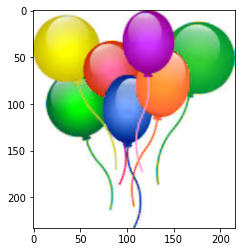

In [64]:
plt.imshow(c_opt)

In [42]:
np.unique(c_opt[c_opt<0])

array([], dtype=float32)

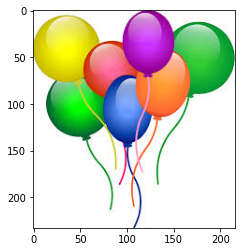

In [43]:
plt.imshow(im)